In [9]:
import pandas as pd
stock = pd.read_csv("TSLA.csv")
stock.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000,2.416000e+03
mean,186.271147,189.578224,182.916639,186.403651,186.403651,5.572722e+06
std,118.740163,120.892329,116.857591,119.136020,119.136020,4.987809e+06
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,34.342498,34.897501,33.587501,34.400002,34.400002,1.899275e+06
50%,213.035004,216.745002,208.870002,212.960007,212.960007,4.578400e+06
75%,266.450012,270.927513,262.102501,266.774994,266.774994,7.361150e+06
max,673.690002,786.140015,673.520020,780.000000,780.000000,4.706500e+07


In [10]:
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [11]:
stock = pd.DataFrame(stock)
stock['Movement'] = stock['Close'].diff().apply(lambda x: 'up' if x>0 else ('down' if x<0 else None))
stock['Movement'] = stock['Movement'].map({'down':0, 'up':1})
stock = stock.dropna()
stock.head()

X = stock.drop(columns = ['Date', 'Movement'])
y = stock['Movement']

from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y  = train_test_split(X,y,random_state = 1, shuffle = False, test_size = 0.2)

#You should always scale after the split (otherwise there will be daat leakage)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
val_X = scaler.transform(val_X)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Validation Loss 0.4336
Best Validation Accuracy 0.8216


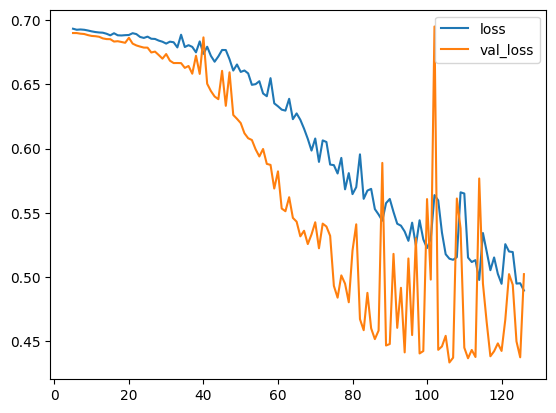

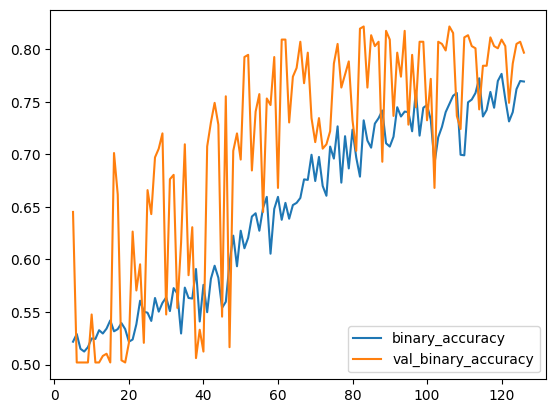

In [14]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

model = keras.Sequential([
    layers.Dense(units = 64, activation = 'relu', input_shape = [6]),
    layers.Dropout(0.2),
    layers.Dense(units = 64, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(units = 1, activation = 'sigmoid')
])

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['binary_accuracy']
)

early_stopping = EarlyStopping(
    min_delta = 0.001,
    patience = 20,
    restore_best_weights = True
)

history = model.fit(
    train_X, train_y,
    validation_data = (val_X, val_y),
    batch_size = 64,
    epochs = 1000,
    callbacks = [early_stopping],
    verbose = 0
)

import matplotlib.pyplot as plt
history_df = pd.DataFrame(history.history)
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()


print('Best Validation Loss {:0.4f}\nBest Validation Accuracy {:0.4f}'\
      .format(history_df['val_loss'].min(),
              history_df['val_binary_accuracy'].max()))

In [16]:
#This is to test if the 81% accuracy is real by making a confusion matrix

from sklearn.metrics import confusion_matrix, classification_report
pred_y = (model.predict(val_X)>0.5).astype(int)
print(confusion_matrix(val_y, pred_y))
print("[TN FP]")
print("[FN TP]")
print(classification_report(val_y, pred_y))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
[[191  49]
 [ 37 205]]
[TN FP]
[FN TP]
              precision    recall  f1-score   support

         0.0       0.84      0.80      0.82       240
         1.0       0.81      0.85      0.83       242

    accuracy                           0.82       482
   macro avg       0.82      0.82      0.82       482
weighted avg       0.82      0.82      0.82       482

